In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import sys
print(sys.executable)

/bin/python3


In [4]:
!jupyter kernelspec list

Available kernels:
  python3    /cluster/home/9339yk/.local/share/jupyter/kernels/python3


In [5]:
import glob
# import imageio as iio
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from skimage import color
from skimage import io
from skimage.transform import resize

2023-11-30 14:26:09.145933: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 14:26:09.801516: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 14:26:11.468140: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 14:26:11.468162: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 14:26:11.473798: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        print('enable gpu')
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2023-11-30 14:26:20.024290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 14:26:20.025014: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
ROOT_FILE_PATH = "../REAL"
AREAS = ["prf-visualrois", "floc-bodies", "floc-faces", "floc-places", "floc-words", "streams", "all-vertices"]
MASK_KEYS = ["lh.fsaverage_space", "rh.fsaverage_space", "lh.space", "rh.space", "mapping"]

In [8]:
def ReadNpyFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename] = np.load(path, allow_pickle = True)
  return return_dic

def ReadFmriFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    return_dic[filename[0]] = np.load(path, allow_pickle = True)
  return return_dic

def ReadMaskFile(dir_path):
  return_dic = {area: {} for area in AREAS}
  for path in glob.glob(dir_path + "/*.npy"):
    filename = os.path.splitext(path)[0].split("/")[-1]
    for area in AREAS:
      if area in filename:
        filename = "".join(i.strip("_") for i in filename.split(area))
        return_dic[area][filename] = np.load(path, allow_pickle = True) if filename[0] != "m" else np.load(path, allow_pickle = True).item()
        break
  return return_dic

def FetchPngFile(dir_path, index, mode = "rgb"):
  # img = iio.v3.imread()
  img = io.imread(os.path.join(dir_path, f'{index}.png'))
  if mode == "rgb":
    return img
  if mode == "hsv":
    return color.rgb2hsv(img)
    # return matplotlib.colors.rgb_to_hsv(img)
  if mode == "gray":
    return color.rgb2gray(img)
    # return np.dot(img, [0.299, 0.587, 0.114])

In [9]:
def train_val_split(x, y, ratio, random_state=42):
  
  r = np.random.RandomState(random_state)
  
  idx = r.permutation(x.index)
  x_per = x.reindex(idx)
  y_per = y.reindex(idx)

  train_size = int(x.shape[0] * ratio)
  
  x_train = x_per[0:train_size]
  y_train = y_per[0:train_size]
  
  x_val = x_per[train_size:]
  y_val = y_per[train_size:]
  
  print('Training_dimension: ' + str(x_train.shape) + ' | ' + str(y_train.shape))
  print('Validation_dimension: ' + str(x_val.shape) + ' | ' + str(y_val.shape))

  return x_train, x_val, y_train, y_val

In [10]:
class ReadObject:
  
  fmri = None           # dict(string -> ndarray, float32)
  masks = None          # dict(string "AREA" -> (dict(int -> string), string "HEMISPHERE, " -> ndarray))
  
  image_labels = None   # dataframe
  label_names = None    # list

  subject = None        # string
  
  def __init__(self, subject):
    self.subject = subject

  # Mode = "train" | "test"
  def load(self, mode = "train"):
    
    self.image_labels = pd.read_csv(os.path.join(ROOT_FILE_PATH, "image_infos", f"{self.subject}_infos_train.csv"))
    self.image_labels = self.image_labels.drop(self.image_labels.columns[[0, 1]], axis=1)
    self.label_names = self.image_labels.columns
    
    self.image_labels = self.image_labels.to_numpy(dtype=int)

    print('Images: ' + str(self.image_labels.shape[0]))
    print('Labels: ' + str(self.image_labels.shape[1]))
    
    self.masks = ReadMaskFile(os.path.join(ROOT_FILE_PATH, self.subject , "roi_masks"))
    print('Masks: ' + str(len(self.masks.keys())))
        
    if mode == "train":
      self.fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_fmri"))
    elif mode == "test":
      self.fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "test_split", "test_fmri"))

  def split_data(self, count=None, ratio=None, permutate=True, image_mode = "rgb", random_state=42):
    
    if ratio is None:
      ratio = 1
    
    random_state = np.random.RandomState(random_state)
    
    if count is not None and count > 0:
      fmri_l_copy = self.fmri['l'][:count]
      fmri_r_copy = self.fmri['r'][:count]
      labels_copy = self.image_labels[:count]
    else:
      fmri_l_copy = self.fmri['l']
      fmri_r_copy = self.fmri['r']
      labels_copy = self.image_labels
    
    loaded_images = np.stack([FetchPngFile(os.path.join(ROOT_FILE_PATH, self.subject,
                      "training_split", "training_images"), i, mode = image_mode) for i in range(labels_copy.shape[0])])
    
    if permutate:
      
        idx = random_state.permutation(labels_copy.shape[0])
        
        fmri_l_copy = fmri_l_copy[idx]
        fmri_r_copy = fmri_r_copy[idx]
        labels_copy = labels_copy[idx]
        loaded_images = loaded_images[idx]
        
    train_size = int(labels_copy.shape[0] * ratio)
  
    fmri_l_train = fmri_l_copy[0:train_size]
    fmri_r_train = fmri_r_copy[0:train_size]
    labels_train = labels_copy[0:train_size]
    images_train = loaded_images[0:train_size]
    
    fmri_l_val = fmri_l_copy[train_size:]
    fmri_r_val = fmri_r_copy[train_size:]
    labels_val = labels_copy[train_size:]
    images_val = loaded_images[train_size:]
    
    return (labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val)

In [11]:
%matplotlib inline
def test_data(label_names, labels_list, image, fmri_l, fmri_r):
  labels = np.array(label_names)[np.where(labels_list != 0)] 
  print(labels)
  plt.imshow(image)
  plt.show()

In [12]:
SUBJ_LIST = ["subj01", "subj02", "subj03", "subj04", "subj05", "subj06", "subj07", "subj08"]

In [13]:
def min_max_normalize(X, min=0, max=1):
  
  # Define the original range
  old_min = np.min(X)
  old_max = np.max(X)
  
  # Map the values from the original range to the new range
  X = (X - old_min) * (max - min) / (old_max - old_min) + min
  
  return X

In [14]:
global_labels_name = None
global_labels_train = None
global_labels_val = None
global_fmri_l_train = None
global_fmri_l_val = None
global_fmri_r_train = None
global_fmri_r_val = None
global_images_train = None
global_images_val = None

subject_count = 2

for sub in SUBJ_LIST[:subject_count]:
  
  print(sub)
  
  sub_obj = ReadObject(sub)
  sub_obj.load()
  
  global_labels_name = sub_obj.label_names if global_labels_name is None else global_labels_name
  
  (
    (labels_train, labels_val), (fmri_l_train, fmri_l_val),
    (fmri_r_train, fmri_r_val), (images_train, images_val)
  ) = (sub_obj.split_data(count=5000, ratio=0.995, image_mode= "gray"))
  
  print(labels_train.shape)
  global_labels_train = labels_train if global_labels_train is None else np.vstack((global_labels_train, labels_train))
  
  print(labels_val.shape)
  global_labels_val = labels_val if global_labels_val is None else np.vstack((global_labels_val, labels_val))
  
  fmri_l_train = min_max_normalize(fmri_l_train)
  print(fmri_l_train.shape)
  global_fmri_l_train = fmri_l_train if global_fmri_l_train is None else np.vstack((global_fmri_l_train, fmri_l_train))
  
  fmri_l_val = min_max_normalize(fmri_l_val)
  print(fmri_l_val.shape)
  global_fmri_l_val = fmri_l_val if global_fmri_l_val is None else np.vstack((global_fmri_l_val, fmri_l_val))
  
  fmri_r_train = min_max_normalize(fmri_r_train)
  print(fmri_r_train.shape)
  global_fmri_r_train = fmri_r_train if global_fmri_r_train is None else np.vstack((global_fmri_r_train, fmri_r_train))
  
  fmri_r_val = min_max_normalize(fmri_r_val)
  print(fmri_r_val.shape)
  global_fmri_r_val = fmri_r_val if global_fmri_r_val is None else np.vstack((global_fmri_r_val, fmri_r_val))
  
  print(images_train.shape)
  global_images_train = images_train if global_images_train is None else np.vstack((global_images_train, images_train))
  
  print(images_val.shape)
  global_images_val = images_val if global_images_val is None else np.vstack((global_images_val, images_val))

subj01
Images: 5000
Labels: 133
Masks: 7


(4975, 133)
(25, 133)
(4975, 19004)
(25, 19004)
(4975, 20544)
(25, 20544)
(4975, 425, 425)
(25, 425, 425)
subj02
Images: 5000
Labels: 133
Masks: 7
(4975, 133)
(25, 133)
(4975, 19004)
(25, 19004)
(4975, 20544)
(25, 20544)
(4975, 425, 425)
(25, 425, 425)


In [15]:
print(global_labels_train.shape)
print(global_labels_val.shape)
print(global_fmri_l_train.shape)
print(global_fmri_l_val.shape)
print(global_fmri_r_train.shape)
print(global_fmri_r_val.shape)
print(global_images_train.shape)
print(global_images_val.shape)

(9950, 133)
(50, 133)
(9950, 19004)
(50, 19004)
(9950, 20544)
(50, 20544)
(9950, 425, 425)
(50, 425, 425)


['person' 'airplane' 'window-other']


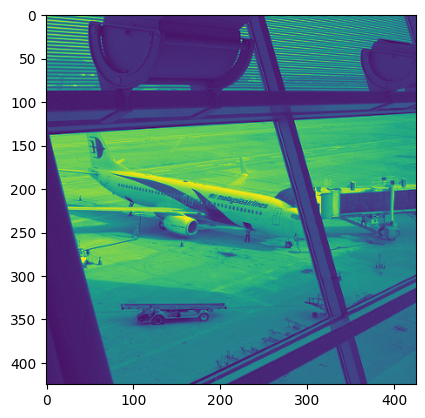

In [16]:
index = 183
test_data(global_labels_name, global_labels_train[index], global_images_train[index], None, None)

In [17]:
print(global_fmri_l_train.shape)
print(global_fmri_r_train.shape)
global_X_train = np.concatenate((global_fmri_l_train, global_fmri_r_train), axis=1)

print(global_X_train.shape)

print(global_fmri_l_val.shape)
print(global_fmri_r_val.shape)
global_X_val  = np.concatenate((global_fmri_l_val, global_fmri_r_val), axis=1)

print(global_X_val.shape)

(9950, 19004)
(9950, 20544)


(9950, 39548)
(50, 19004)
(50, 20544)
(50, 39548)


In [18]:
print(np.max(global_X_train))
print(np.min(global_X_train))

1.0
0.0


In [19]:
global_Y_train_classification = global_labels_train
print(global_Y_train_classification.shape)

(9950, 133)


In [20]:
from tensorflow import keras

In [21]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(filters=32, kernel_size=(5,), input_shape=(39548, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv1D(filters=32, kernel_size=(5,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.MaxPool1D())

model.add(keras.layers.Conv1D(filters=64, kernel_size=(4,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv1D(filters=64, kernel_size=(4,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.MaxPool1D())

model.add(keras.layers.Conv1D(filters=128, kernel_size=(3,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Conv1D(filters=128, kernel_size=(3,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.MaxPool1D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))

model.add(keras.layers.Dense(133, activation="softmax"))

model.compile(optimizer="sgd", loss="mse", metrics=['accuracy']) # "sgd", keras.optimizers.Adam(learning_rate=0.000001)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39544, 32)         192       
                                                                 
 batch_normalization (Batch  (None, 39544, 32)         128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 39544, 32)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 39540, 32)         5152      
                                                                 
 batch_normalization_1 (Bat  (None, 39540, 32)         128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 39540, 32)         0

In [22]:
history = model.fit(global_X_train.reshape(-1, global_X_train.shape[1], 1), global_labels_train, validation_data=(global_X_val, global_labels_val), batch_size=64, epochs=10)

# Accessing training history
# training_loss = history.history['loss']
# training_accuracy = history.history['accuracy']
# validation_loss = history.history['val_loss']
# validation_accuracy = history.history['val_accuracy']

# Printing training and validation loss and accuracy
# for i in range(len(training_loss)):
#     print(f"Epoch {i+1}: Training Loss: {training_loss[i]}, Training Accuracy: {training_accuracy[i]}, Validation Loss: {validation_loss[i]}, Validation Accuracy: {validation_accuracy[i]}")


Epoch 1/10
  6/156 [>.............................] - ETA: 9:03 - loss: 0.0519 - accuracy: 0.0000e+00

: 

In [ ]:
prediction_model = model.predict(global_X_val.reshape(-1, global_X_train.shape[1], 1))
print(prediction_model.shape)


2/2 [==============================] - 0s 16ms/step
(50, 133)


In [ ]:
indices = np.where(prediction_model == 1)
print(indices)

NameError: name 'np' is not defined

In [ ]:
# Fill with zeros till 40000
target_size = 40000

additional_rows = np.zeros(shape=(global_X_train.shape[0], target_size - global_X_train.shape[1]))
print(additional_rows.shape)

expanded_40000_X_train = np.concatenate((global_X_train, additional_rows), axis=1)
print(expanded_40000_X_train.shape)

additional_rows2 = np.zeros(shape=(global_X_val.shape[0], target_size - global_X_val.shape[1]))
expanded_40000_X_val = np.concatenate((global_X_val, additional_rows2), axis=1)
print(expanded_40000_X_val.shape)

In [ ]:
count = 5000
resized_300_Y_train_images = np.zeros((count, 300, 300, 3))
for index in range(count):
  if index % 50 == 0:
    print(index)
  resized_300_Y_train_images[index] = resize(global_images_train[index], (300, 300, 3), anti_aliasing=True)
print(resized_300_Y_train_images.shape)

In [ ]:
encoder1 = keras.models.Sequential()

encoder1.add(keras.layers.Conv2D(1, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(200, 200, 1)))
encoder1.add(keras.layers.BatchNormalization())

encoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="sigmoid"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

encoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

encoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
encoder1.add(keras.layers.BatchNormalization())
encoder1.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder1.summary()

decoder1 = keras.models.Sequential()

decoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(25, 25, 128)))
decoder1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="sigmoid"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(3, 3)))

decoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(2, 2)))

decoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
decoder1.add(keras.layers.BatchNormalization())
decoder1.add(keras.layers.UpSampling2D(size=(2, 2)))

decoder1.add(keras.layers.Conv2D(3, kernel_size=(3, 3), padding="same", activation="sigmoid"))
decoder1.summary()

In [ ]:
model1 = keras.models.Sequential()
model1.add(encoder1)
model1.add(decoder1)

model1.compile(optimizer="sgd", loss="mse") # "adam", "rmsprop"

In [ ]:
model1.fit(expanded_40000_X_train.reshape(-1, 200, 200)[:count], resized_300_Y_train_images, batch_size=32, epochs=10)

In [ ]:
prediction_model1 = model1.predict(expanded_40000_X_val.reshape(-1, 200, 200))
print(prediction_model1.shape)

In [ ]:
index = 4
test_data(global_labels_name, global_labels_val[index], global_images_val[index], None, None)
test_data(global_labels_name, global_labels_val[index], prediction_model1[index], None, None)

In [ ]:
count = 5000
resized_200_Y_train_images = np.zeros((count, 200, 200, 3))
for index in range(count):
  if index % 1000 == 0:
    print(index)
  resized_200_Y_train_images[index] = resize(global_images_train[index], (200, 200, 3), anti_aliasing=True)
print(resized_200_Y_train_images.shape)

In [ ]:
encoder2 = keras.models.Sequential()

encoder2.add(keras.layers.Conv2D(32, kernel_size=4, strides=2, input_shape=(200, 200, 1)))
encoder2.add(keras.layers.BatchNormalization())
encoder2.add(keras.layers.LeakyReLU())
encoder2.add(keras.layers.Dropout(0.1))

encoder2.add(keras.layers.Conv2D(64, kernel_size=3, strides=2))
encoder2.add(keras.layers.BatchNormalization())
encoder2.add(keras.layers.LeakyReLU())
encoder2.add(keras.layers.Dropout(0.1))
encoder2.summary()

bridge2 = keras.models.Sequential()

bridge2.add(keras.layers.Conv2D(128, kernel_size=3, strides=2, input_shape=(49, 49, 64)))
bridge2.summary()

decoder2 = keras.models.Sequential()

decoder2.add(keras.layers.BatchNormalization(input_shape=(24, 24, 128)))
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2))
decoder2.add(keras.layers.BatchNormalization())
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2))
decoder2.add(keras.layers.BatchNormalization())
decoder2.add(keras.layers.LeakyReLU())
decoder2.add(keras.layers.Dropout(0.1))

decoder2.add(keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2))

decoder2.summary()

In [ ]:
model2 = keras.models.Sequential()

model2.add(encoder2)
model2.add(bridge2)
model2.add(decoder2)

model2.summary()
model2.compile(optimizer="rmsprop", loss="mse")

In [ ]:
model2.fit(expanded_40000_X_train.reshape(-1, 200, 200)[:count], resized_200_Y_train_images, batch_size=64, epochs=60)

In [ ]:
prediction_model2 = model2.predict(expanded_40000_X_val.reshape(-1, 200, 200))
print(prediction_model2.shape)

In [ ]:
index = 4
test_data(global_labels_name, global_labels_val[index], global_images_val[index], None, None)
test_data(global_labels_name, global_labels_val[index], prediction_model2[index], None, None)